In [1]:
import json
import requests
#from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Required for formatting dates later in the case
import datetime
import matplotlib.dates as mdates

In [2]:
# Load a file as a DataFrame and assign to df
df = pd.read_excel("Data/Antecedentes_patologicos.xlsx")

In [3]:
df.keys()

Index(['DS_IDENTIFICACION', 'EPS', 'FE_ACTUALIZA', 'FE_INICIO', 'FE_FIN',
       'DS_OBSERVACIONES', 'Diagnostico', 'CodDiagnostico'],
      dtype='object')

In [4]:
col = np.char.lower(np.array(df.keys(), dtype='U'))
col[0] = 'id'
df.columns = col

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2086 entries, 0 to 2085
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                2086 non-null   int64         
 1   eps               2086 non-null   object        
 2   fe_actualiza      2086 non-null   datetime64[ns]
 3   fe_inicio         2034 non-null   datetime64[ns]
 4   fe_fin            148 non-null    datetime64[ns]
 5   ds_observaciones  58 non-null     object        
 6   diagnostico       2085 non-null   object        
 7   coddiagnostico    2085 non-null   object        
dtypes: datetime64[ns](3), int64(1), object(4)
memory usage: 130.5+ KB


Fecha fin, tiene muchos faltantes, observaciones igual. No los tomaria. 

Ahora me quedo con eps, se cambia el codigo de diagnostico por el grupo, mas adelante se pone referencia.
Resta analizar con cual fecha nos quedamos.

In [6]:
# Cambiar texto a minuscula.
a = df['eps'].dtype

for col in df.columns:
    if df[col].dtype == a:
        df[col] = df[col].str.lower()

In [7]:
df

,id,eps,fe_actualiza,fe_inicio,fe_fin,ds_observaciones,diagnostico,coddiagnostico
0,653834,eps/sura,2010-10-10,2010-10-09,NaT,NaN,trasplante de corazon,z941
1,653834,eps/sura,2012-10-17,2012-10-17,NaT,NaN,otras dermatitis atopicas,l208
2,653834,eps/sura,2012-10-17,2012-10-17,NaT,NaN,"rinitis alergica, no especificada",j304
3,653834,eps/sura,2017-08-01,2011-03-02,NaT,NaN,asma predominantemente alergica,j450
4,653834,eps/sura,2012-10-17,2012-10-17,NaT,NaN,choque anafilactico debido a reaccion adversa ...,t780
...,...,...,...,...,...,...,...,...
2081,1370054,eps/sura,2020-03-24,2020-03-24,NaT,NaN,urticaria alergica,l500
2082,1370054,eps/sura,2020-04-28,2020-04-28,NaT,NaN,urticaria idiopatica,l501
2083,1370148,eps/sura,2020-03-27,2017-03-18,NaT,NaN,"urticaria, no especificada",l509
2084,1311280,eps/sura,2020-03-27,2020-03-20,NaT,NaN,urticaria idiopatica,l501


Extraer el codigo de diagnostico: Para la interpretación https://es.wikipedia.org/wiki/Anexo:C%C3%B3digos_CIE-10

De entrada nos interesa los codigos J y Z

In [8]:
df["codigo"] = df["coddiagnostico"].apply(
    lambda x: str(x)[0])

In [9]:
df

,id,eps,fe_actualiza,fe_inicio,fe_fin,ds_observaciones,diagnostico,coddiagnostico,codigo
0,653834,eps/sura,2010-10-10,2010-10-09,NaT,NaN,trasplante de corazon,z941,z
1,653834,eps/sura,2012-10-17,2012-10-17,NaT,NaN,otras dermatitis atopicas,l208,l
2,653834,eps/sura,2012-10-17,2012-10-17,NaT,NaN,"rinitis alergica, no especificada",j304,j
3,653834,eps/sura,2017-08-01,2011-03-02,NaT,NaN,asma predominantemente alergica,j450,j
4,653834,eps/sura,2012-10-17,2012-10-17,NaT,NaN,choque anafilactico debido a reaccion adversa ...,t780,t
...,...,...,...,...,...,...,...,...,...
2081,1370054,eps/sura,2020-03-24,2020-03-24,NaT,NaN,urticaria alergica,l500,l
2082,1370054,eps/sura,2020-04-28,2020-04-28,NaT,NaN,urticaria idiopatica,l501,l
2083,1370148,eps/sura,2020-03-27,2017-03-18,NaT,NaN,"urticaria, no especificada",l509,l
2084,1311280,eps/sura,2020-03-27,2020-03-20,NaT,NaN,urticaria idiopatica,l501,l


## ID analisis ##

In [10]:
id_df = pd.DataFrame(df["id"].value_counts()).reset_index()
id_df.columns = ['id', 'count']
print(id_df['count'].sum())
id_df

2086


,id,count
0,758174,40
1,674247,40
2,1263349,40
3,716377,30
4,1240215,29
...,...,...
842,1177168,1
843,695889,1
844,1051546,1
845,1463896,1


C:\Users\Beto\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Text(0.5, 0.98, 'Global de Antecedendes según Código')

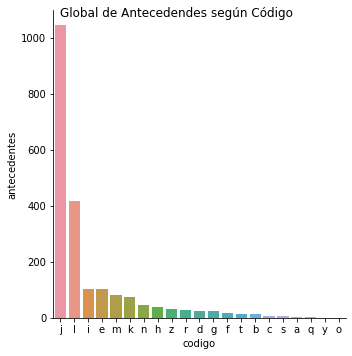

In [18]:
plot_df = pd.DataFrame(df["codigo"].value_counts()).reset_index()
plot_df.columns = ['codigo','antecedentes']
f = sns.factorplot(x='codigo', y='antecedentes', data=plot_df, kind='bar')
f.fig.suptitle('Global de Antecedendes según Código')

In [ ]:
plot_df[plot_df['codigo']=='j']

In [12]:
df = df.drop(columns=['fe_fin','fe_inicio','ds_observaciones','diagnostico','coddiagnostico'])
df.columns = ['id','eps','fecha','codigo']

,id,eps,fe_actualiza,fe_inicio,codigo
0,653834,eps/sura,2010-10-10,2010-10-09,z
1,653834,eps/sura,2012-10-17,2012-10-17,l
2,653834,eps/sura,2012-10-17,2012-10-17,j
3,653834,eps/sura,2017-08-01,2011-03-02,j
4,653834,eps/sura,2012-10-17,2012-10-17,t
...,...,...,...,...,...
2081,1370054,eps/sura,2020-03-24,2020-03-24,l
2082,1370054,eps/sura,2020-04-28,2020-04-28,l
2083,1370148,eps/sura,2020-03-27,2017-03-18,l
2084,1311280,eps/sura,2020-03-27,2020-03-20,l
